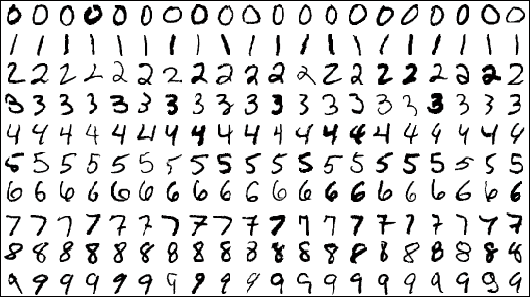

# MNIST - Digit Classifier

O objetivo desse projeto é fazer uso dos dados do Conjunto MNIST para que possamos fazer o reconhecimento de algarismos escritos à mão.

## Dataset e Problema

O objetivo em questão é fazer a classificação de diversos algarismos escritos à mão.

Os dados pertencem ao conjunto MNIST e são famosos por serem usados para treinar classificadores. Os dados, apesar de serem dados de imagem, já vem em formato estruturado, cada imagem de 28x28 pixels foi transofrmada em uma observação no dataset (linha) e cada pixel da imagem foi transformado em uma coluna assumindo o valor de 0 ou 1 referente a um ponto não preenchido ou preenchido da imagem em preto e branco.

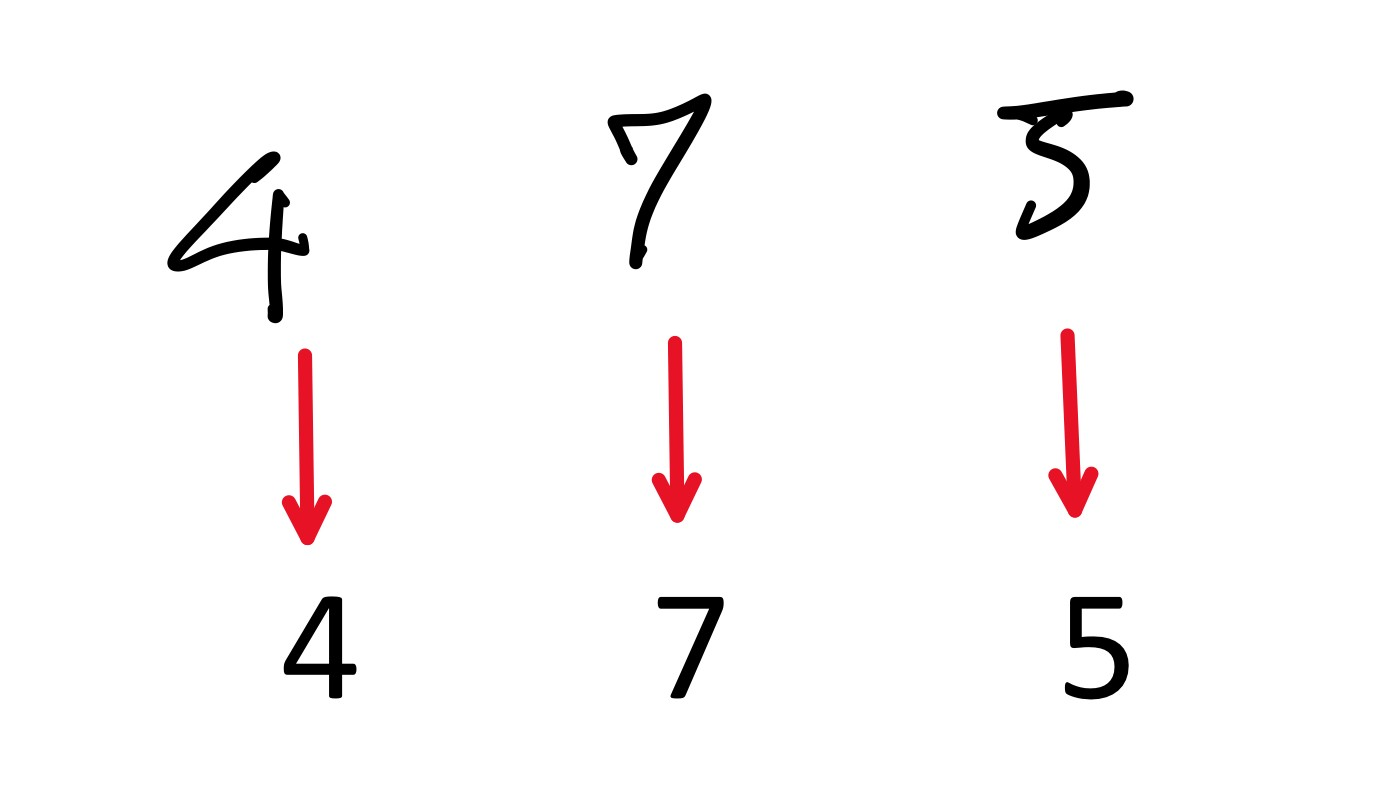

Os dados usado foram retirados do site de machine learning Kaggle e estão dispóniveis na aba data do link a seguir: 

https://www.kaggle.com/competitions/digit-recognizer/overview



O dataset, carregado a seguir, está dividido em Treino e Teste, onde o conjunto de teste contêm apenas as colunas de pixels com o objetivo de fazer a submissão do desafio. (28000 linhas) 

O conjunto de treino tem uma coluna de label, que informa qual o algarismo da imagem e as outras 784 colunas dos pixels. (42000 linhas)



## Bibliotecas

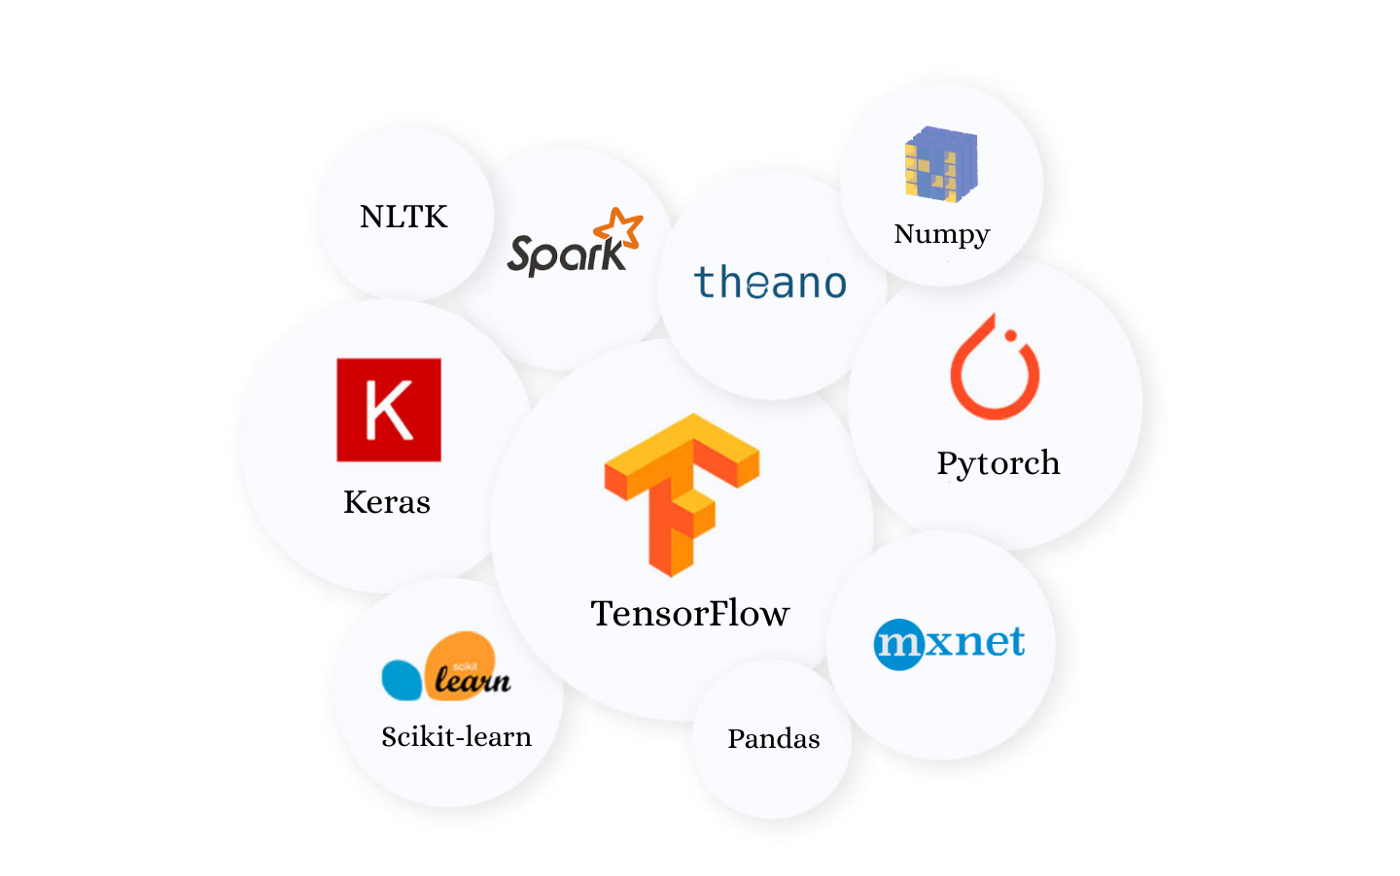

Para esse projeto, usaremos diversas bibliotecas, a maioria disponível na instalação padrão do anaconda. Porém qualquer outra biblioteca usada que não vier, pode ser instalada pelo terminal ou linha de comando com o pip.

As principais biblioteceas usadas são:

- Pandas: Para manipulação de dados em estrutura de Dataframe, com agilidade e performance.
- Numpy:  Com o objetivo de manipular dados de maneira eficiente e com diversas funções matemáticas disponíveis.
- Matplotlib: Usada para criar visualizações de maneira rápida e simples.
- Seaborn: Visualizações mais avançadas e pré-prontas com menos necessidade de personalização para atingir uma alta qualidade.
- Scikit-Learn: Biblioteca de Machine Learning com o objetivo de fazer pré-processamentos nos dados, testar e metrificar diversos modelos.

Outras bibliotecas podem ser usadas ao longo do projeto, todas estarão listadas no carregamento feito a seguir porém as principais foram as listadas anteriormente.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime


import warnings
warnings.filterwarnings('ignore')

## Dados 

Vamos agora carregar os datasets de treino e teste, as colunas de ambas são iguais, exceto pela coluna label que está apenas no conjunto de treino (indicando qual algarismo a imagem se refere). Todas as outras colunas são de valor 1 ou 0 dos pixels pretos ou brancos.

Vamos chamar o conjunto teste de conjunto submit, dados que usaremos ele apenas para a submissão, e não para testar a performance do modelo.

In [2]:
df_treino = pd.read_csv('dados/train.csv')
df_submit  = pd.read_csv('dados/test.csv')
df_treino_pix = df_treino.drop(axis = 1,labels = ['label'])

df_treino.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


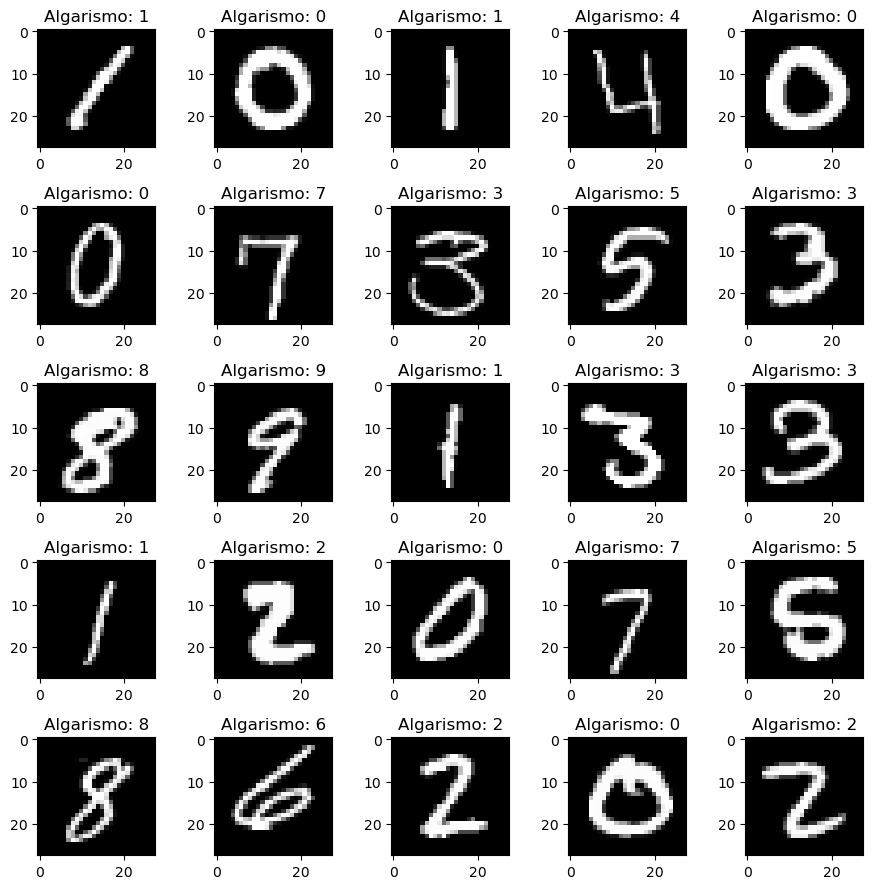

In [3]:
fig, axes = plt.subplots(5,5, figsize=(9,9))

for i in range(25):
    ax = axes[i//5, i%5]
    img = np.array(df_treino_pix.iloc[i]).reshape([28,28])
    ax.imshow(img, cmap = 'gray')
    ax.set_title(f"Algarismo: { df_treino['label'][i] }")

plt.tight_layout()
plt.show()

Vamos dar uma rápida conferida se não temos dados faltantes, conjuntos de dados do Kaggle (diferentes dos que costumam ser usados no dia-a-dia) já costumam vir organizados e totalmente preenchidos, porém segue sendo uma boa prática.

In [4]:
print(f"Quantidade de dados NA no conjunto de treino: {df_treino.isna().sum().sum()}")
print(f"Quantidade de dados NA no conjunto de submit: {df_submit.isna().sum().sum()}")

np.sort( df_treino['label'].unique())

Quantidade de dados NA no conjunto de treino: 0
Quantidade de dados NA no conjunto de submit: 0


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

Podemos observar que não temos dados faltantes, também vimos que os labels são somente os algarismos e não temos nada diferente do esperado. Vamos agora conferir se não existe uma discrepância grande entre a frequência dos números, que pode ser um problema para a classificação. Se existir, podemos ajustar os limiares ou usar uma técnica de oversampling para minimizar o problema.

<AxesSubplot:title={'center':'Frequência absoluta dos algarismos'}>

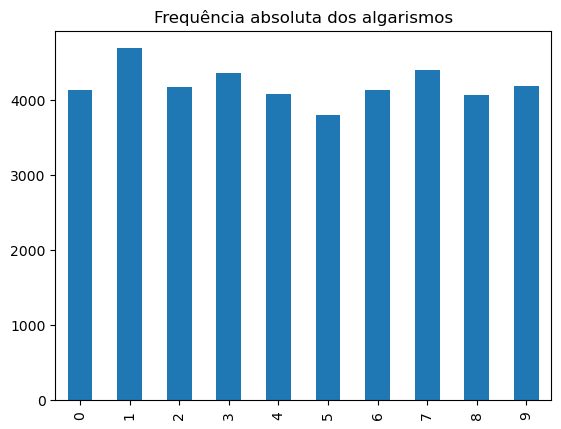

In [5]:
df_treino['label'].value_counts().sort_index().plot(kind = 'bar',title = 'Frequência absoluta dos algarismos') ## As frequências
# absolutas dos dados não são diferentes o suficiente para justificar um método de equilibrio nos dados, dessa maneira podemos
# seguir para a classificação.

## Classificação

Vamos agora testar alguns classificadores para tentar discriminar os números. Os principais modelos que vamos treinar 3 modelos de classificação, listados a seguir. Além disso depois faremos uma alteração do dataset por meio de um PCA (Análise de Componentes Principais) com o objetivo de diminuir a quantidade de variáveis encontrando variáveis que tem muito em comum, dessa maneira o desempenho pode piorar um pouco, porém o modelo deve ser mais performático em relação ao tempo de execução.

Os modelos que usaremos são:

- K-Nearest-Neighbours (KNN): O modelo dos K vizinhos mais próximos é um modelo não parámetrico supervisionado. Pode ser usado para classificação ou regressão. Ele funciona calculando as distâncias de todos os pontos entre si, e na classificação atribuindo a classe dos k vizinhos mais próximos para o ponto sendo previsto. Para a regressão é calculado o valor médio dos k vizinhos para ser o estimador do ponto.

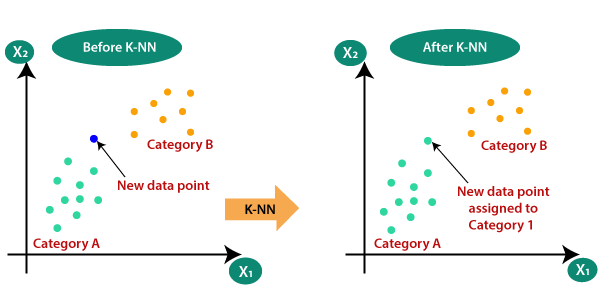

- Support Vector Machine (SVM): A máquina de vetores de suporte é outro modelo que pode ser usado para classificação ou regressão. O modelo faz uma divisão do espaço (no caso de diversas variáveis um hiperplano) entre dados de diversas classes e depois estima a classe baseado em qual subdivisão do espaço os pontos se encontram.

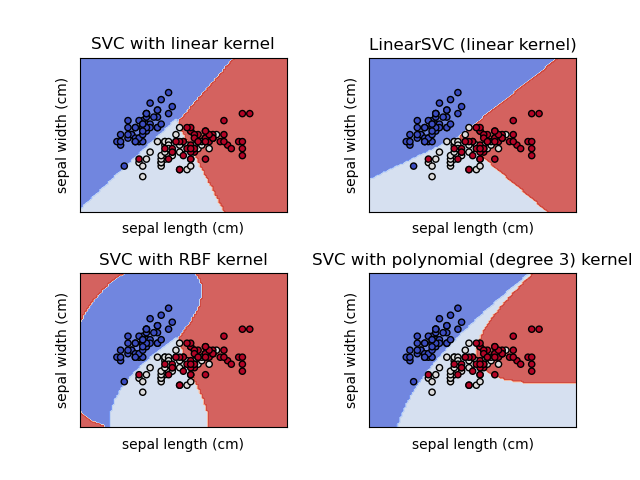

- Random Forest (RF) : A floresta aleatória é um modelo ensemble que cria diversas árvores de decisão e para o caso da classificação faz uma "votação" entre o que cada árvore retornou para definir qual a classe do novo ponto. As diversas árvores criadas passam por um processo de bagging que seleciona um conjunto diferente de variáveis aleatoriamente para cada árvore, isso ajuda a melhorar a precisão e diminuir o overfitting em relação as árvores de decisão.

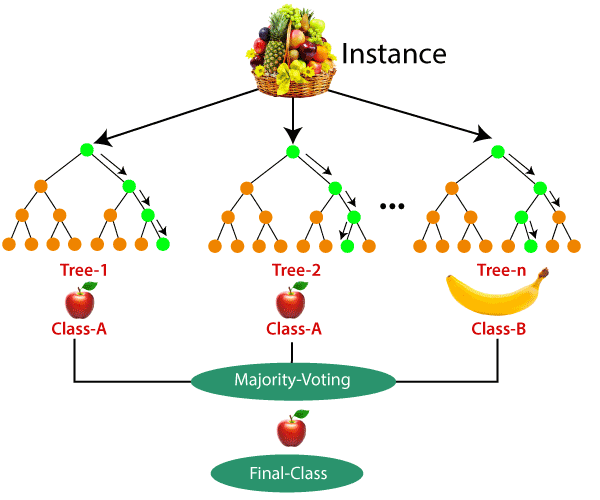

Agora que mostramos o modelo que iremos usar, vamos fazer uma divisão dos dados em treino e teste para testar a acurácia do modelo e outras métricas. Inicialmente faremos uma divisão simples e testaremos os modelos com parâmetros escolhidos manualmente, depois vamos usar um método de cross-validation com grid search para testar diferentes hiperparâmetros para os modelos. Também faremos um PCA para melhorar o tempo de execução caso necessário.

### Train Test Split

Vamos dividir nosso conjunto de dados em treino e teste, vamos escolher hiperparâmetros arbitrários e um split de 20%  dos dados para teste, em segundo momento buscamos melhores práticas com o CrossValidation e Grid Search.  

In [6]:
X, y = df_treino.drop(labels = ['label'],axis = 1), df_treino['label']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state= 42)

### KNN

In [7]:
t_ini = datetime.now()

knn_cl = KNeighborsClassifier(n_neighbors= 3)
knn_cl.fit(X_train,y_train)
prev_knn = knn_cl.predict(X_test)

print(f"Tempo de execução KNN: {round((datetime.now() - t_ini).total_seconds(),1)} segundos")

Tempo de execução KNN: 9.6 segundos


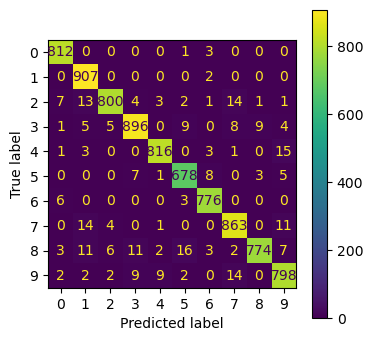

In [8]:
# Agora vamos calcular algumas métricas para esse modelo

mt_conf_display = ConfusionMatrixDisplay.from_predictions( y_test, prev_knn, labels = list(range(10)))

fig = mt_conf_display.ax_.get_figure()

fig.set_figwidth(4)
fig.set_figheight(4) 

Pela matriz de confusão podemos perceber que a maioria das classificações foram feitas corretamente, os principais erros são 2 e 9 sendo classificados como 7, 4 como 9, 7 como 1 e 8 como 5.

Vamos agora calcula 2 outras métricas para comparar os modelos.

- Acurácia: Essa métrica é apenas o total de acertos (diagonal principal da matriz) dividido por todas as previsões (matriz inteira), ela apresenta o percentual de acertos do modelo.

- F1-Score: Essa métrica é uma combinação das métricas de Precisão e Recall (que analisam a quantidade de falsos positivos e negativos), ela é interessante de ser usada especialmente quando temos dados não balanceados dados que a acurácia costuma ser extremamente enganosas em casos não balanceados. Como nossos dados não são muito desbalanceados, vamos usar apenas como auxílio, enquanto a acurácia vai ser nosso ponto principal de decisão.

In [9]:
acuracia_knn = accuracy_score(y_test,prev_knn)

print(f"Acurácia KNN: {acuracia_knn:.5f}\nF1-Score KNN: {f1_score(y_test,prev_knn,average = 'weighted'):.5f}")

Acurácia KNN: 0.96667
F1-Score KNN: 0.96659


### SVM

In [10]:
t_ini = datetime.now()

svm_cl = svm.SVC(C = 1)
svm_cl.fit(X_train,y_train)
prev_svm = svm_cl.predict(X_test)

print(f"Tempo de execução SVM: {round((datetime.now() - t_ini).total_seconds(),1)} segundos")

Tempo de execução SVM: 126.8 segundos


O primeiro ponto a ser levantado é o tempo de execução, enquanto o KNN demorou apenas 8 segundos para rodar, o SVM demorou mais de 2 minutos e meio. Apesar de não ser um tempo longo, temos que considerar que para datasets maiores e ao usar o crossvalidation e gridsearch veremos que esse tempo vai ser muito maior que o KNN. Uma solução que veremos a frente seria usar o PCA para esse modelo caso esteja demorando demais.

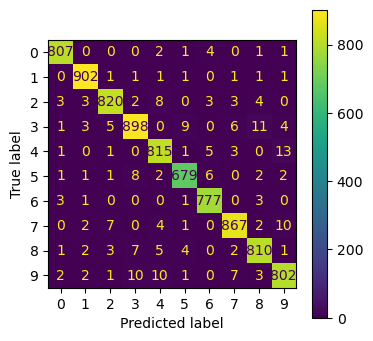

In [11]:
# Agora vamos calcular algumas métricas para esse modelo

mt_conf_display = ConfusionMatrixDisplay.from_predictions( y_test, prev_svm, labels = list(range(10)))

fig = mt_conf_display.ax_.get_figure()

fig.set_figwidth(4)
fig.set_figheight(4) 

Vendo apenas a matriz de confusão, o desempenho do SVM parece ser melhor que o do KNN, porém é difícil de indicar isso apenas visualizando a matriz, vamos apresentar as mesmas métricas para comparar os modelos.

In [12]:
acuracia_svm = accuracy_score(y_test,prev_svm)

print(f"Acurácia SVM: {acuracia_svm:.5f}\nF1-Score SVM: {f1_score(y_test,prev_svm,average = 'weighted'):.5f}")

Acurácia SVM: 0.97345
F1-Score SVM: 0.97343


Comparando os modelos apenas com os hiperparâmetros base e sem tunning, vemos que não existe grande diferença no desempenhos. O SVM é apenas ligeiramente melhor, apenas 0.6% melhor.

#### Random Forest

In [13]:
t_ini = datetime.now()

rf_cl = RandomForestClassifier(n_estimators= 100)
rf_cl.fit(X_train,y_train)
prev_rf = rf_cl.predict(X_test)

print(f"Tempo de execução RF: {round((datetime.now() - t_ini).total_seconds(),1)} segundos")

Tempo de execução RF: 17.9 segundos


O Random Forest, com 100 árvores de decisão também foi bem rápido quando comparado ao SVM, vamos agora analisar as métricas desse modelo.

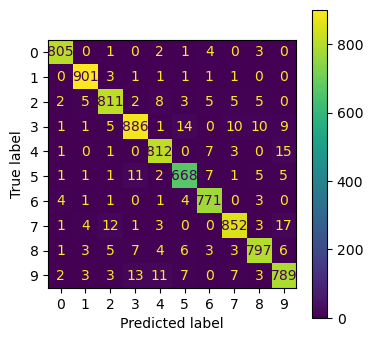

In [14]:
# Agora vamos calcular algumas métricas para esse modelo

mt_conf_display = ConfusionMatrixDisplay.from_predictions( y_test, prev_rf, labels = list(range(10)))

fig = mt_conf_display.ax_.get_figure()

fig.set_figwidth(4)
fig.set_figheight(4) 

Vendo a matriz de confusão o modelo de Floresta Aleatória parece ser o de pior desempenho, vamos imprimir as métricas para comparar.

In [15]:
acuracia_rf = accuracy_score(y_test,prev_rf)

print(f"Acurácia RF: {acuracia_rf:.5f}\nF1-Score RF: {f1_score(y_test,prev_rf,average = 'weighted'):.5f}")

Acurácia RF: 0.96333
F1-Score RF: 0.96330


A floresta aleatória realmente é o modelo de pior desempenho considerando as métricas escolhidas, porém com o tunning isso pode mudar. Além disso, como nossos dados são balanceados podemos ver que usar a métrica de f1 realmente não faz sentido, então para a segunda parte da modelagem, vamos manter apenas a acurácia na análise.

### CrossValidation

O CrossValidation é simplesmente um método de dividir o dataset de treino, em um numero k de folds. Esses folds de tamanho igual são então um de cada vez, não usados para treinarem os modelos mas sim para testar a performance. 

Por exemplo, com 5 folds, dividimos os dados, treinamos com 4/5 e depois testamos no 1/5. Depois pegamos outros 4/5 para treinar e testamos em outro 1/5 dos dados.

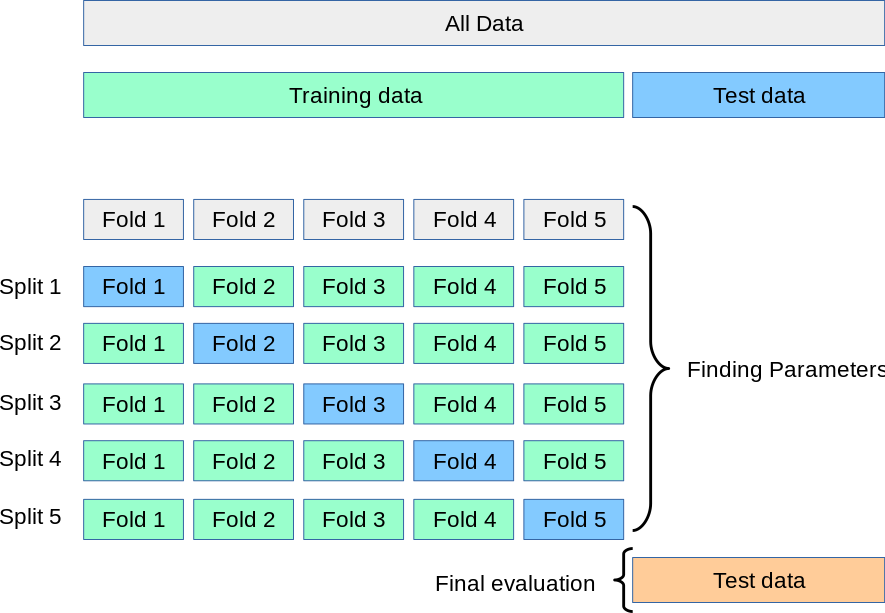

Vamos além de fazer o crossvalidation para analisar performance, para diferentes folds testar diferentes hiperparâmetros de ajuste dos modelos, dessa maneira, ao final escolhemos para o teste o modelo que teve melhor desempenho e usamos ele para previsão.

### KNN - CrossValid

Vamos agora fazer o KNN com o crossvalidation.

In [16]:
t_ini = datetime.now()

knn_params = {"n_neighbors": (3,5,10)}

knn_cl_1 = KNeighborsClassifier()
knn_cl_cv = GridSearchCV(knn_cl_1,knn_params,cv = 5)
knn_cl_cv.fit(X_train,y_train)

print(f"Tempo de execução KNN: {round((datetime.now() - t_ini).total_seconds(),1)} segundos")

Tempo de execução KNN: 85.9 segundos


In [17]:
print(f"Melhores parâmetros: {knn_cl_cv.best_params_}") # Melhores paramêtros.

knn_cl = KNeighborsClassifier(n_neighbors= 5)
knn_cl.fit(X_train,y_train)
prev_knn_fin = knn_cl.predict(X_test)

Melhores parâmetros: {'n_neighbors': 5}


Podemos ver que o tempo de execução do modelo já aumentou bastante com o grid_search. Anteriormente eram 8 segundos para treinar, porém vemos que a melhor quantidade de vizinhos para os dados é 5, então para o modelo final ficaremos com isso. 

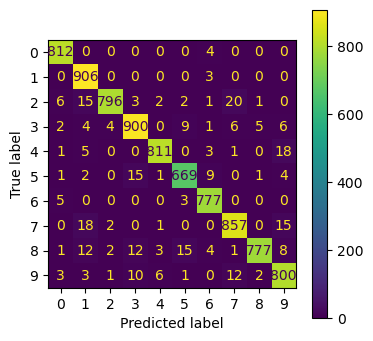

In [18]:
# Agora vamos calcular algumas métricas para esse modelo

mt_conf_display = ConfusionMatrixDisplay.from_predictions( y_test, prev_knn_fin, labels = list(range(10)))

fig = mt_conf_display.ax_.get_figure()

fig.set_figwidth(4)
fig.set_figheight(4) 

In [19]:
acuracia_knn_fin = accuracy_score(y_test,prev_knn_fin)

print(f"Acurácia KNN: {acuracia_knn_fin:.5f}")

Acurácia KNN: 0.96488


Podemos ver que apesar de ter melhor desempenho no Cross Validation com os folds, o desempenho com 5 vizinhos é marginalmente pior que o KNN inicial, o modelo KNN não tem muitos hiperparâmetros para ser alterados, veremos agora o SVM.

### SVM - CrossValid

Veremos agora o CrossValidation com o SVM. Esse modelo já demorou mais para ser treinado sem o GridSearch, então é natural que o processamento agora seja demorado.

In [20]:
t_ini = datetime.now()

svm_params = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

svm_cl_1 = svm.SVC()

svm_cl_cv = GridSearchCV(svm_cl_1,svm_params,cv = 3)

svm_cl_cv.fit(X_train,y_train)


prev_svm_fin = svm_cl_cv.predict(X_test)

print(f"Tempo de execução SVM: {round((datetime.now() - t_ini).total_seconds(),1)} segundos")

Tempo de execução SVM: 941.7 segundos


O tempo de execução extrapolou os 1000 segundos, chegado a 18 minutos. Os paramêtros ideais foram calculados e agora testaremos o modelo novo.

In [21]:
print(f"Melhores parâmetros: {svm_cl_cv.best_params_}") # Melhores paramêtros

Melhores parâmetros: {'C': 10, 'kernel': 'rbf'}


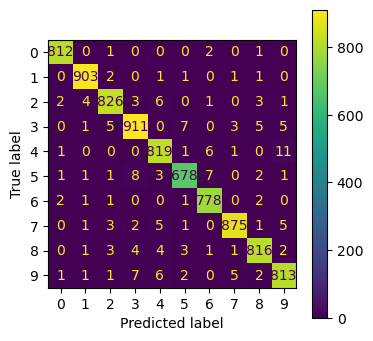

In [22]:
# Agora vamos calcular algumas métricas para esse modelo

mt_conf_display = ConfusionMatrixDisplay.from_predictions( y_test, prev_svm_fin, labels = list(range(10)))

fig = mt_conf_display.ax_.get_figure()

fig.set_figwidth(4)
fig.set_figheight(4) 

O desempenho pela matriz parece ser bom, com poucas aparições de erros grandes. Vamos avaliar a acurácia.

In [23]:
acuracia_svm_fin = accuracy_score(y_test,prev_svm_fin)

print(f"Acurácia SVM: {acuracia_svm_fin:.5f}")

Acurácia SVM: 0.97988


O desempenho desse modelo foi o melhor até agora, com a acurácia ligeiramente melhor que o SVM antes de testar parâmetros. Com um pouco mais de tunning devemos conseguir atingir 98% de desempenho, porém não é o foco aqui. 

### Random Forest - CrossValid

In [24]:
t_ini = datetime.now()

rf_params = {'max_depth': [100,1000,10000, None],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [100, 200, 1000]}

rf_cl_1 = RandomForestClassifier()

rf_cl_cv = GridSearchCV(rf_cl_1,rf_params,cv = 3)

rf_cl_cv.fit(X_train,y_train)


prev_rf_fin = rf_cl_cv.predict(X_test)

print(f"Tempo de execução RF: {round((datetime.now() - t_ini).total_seconds(),1)} segundos")

Tempo de execução RF: 3530.7 segundos


O modelo de Floresta Aleatória tem muito mais personalisações que os anteriores, dessa maneira é natural que o grid search demore muito. Podemos ver que sem trocar tantos parâmetros o tempo de execução subiu para pouco mais de uma hora.

In [25]:
print(f"Melhores parâmetros: {rf_cl_cv.best_params_}") # Melhores paramêtros

Melhores parâmetros: {'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 1000}


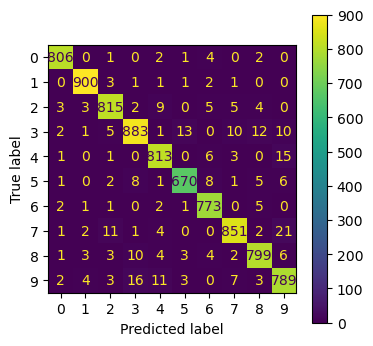

In [26]:
# Agora vamos calcular algumas métricas para esse modelo

mt_conf_display = ConfusionMatrixDisplay.from_predictions( y_test, prev_rf_fin, labels = list(range(10)))

fig = mt_conf_display.ax_.get_figure()

fig.set_figwidth(4)
fig.set_figheight(4) 

In [27]:
acuracia_rf_fin = accuracy_score(y_test,prev_rf_fin)

print(f"Acurácia RF: {acuracia_rf_fin:.5f}")

Acurácia RF: 0.96417


O desempenho foi um pouco melhor que a floresta aleatória sem o tunning de hiperparâmetros. Não trabalhamos transformações nos dados e outros métodos, vamos agora diminuir o número de variáveis com um PCA para testar o desempenho.

## PCA - Performance do Modelo vs Desempenho da Máquina

Agora faremos uma transformação para diminuir a quantidade de variáveis. Por meio de transformações lineares, tentamos encontrar variáveis correlacionadas e reduzir a quantidade de variáveis mantendo um percentual alto da variância explicada, sem necessitar de tantas colunas. As variáveis originais são transformadas nos chamados, componentes principais e a escolha da quantidade de componentes podem ser selecionados de diversas maneiras, normalmente tentando manter um valor alto de variância explicada sem tantas variáveis.

In [28]:
pca = PCA(n_components = 87)
pca.fit(X)
pca.explained_variance_ratio_.cumsum() # Soma cumulativa da variância explicada a cada compontente adicionada.

array([0.09748938, 0.16909204, 0.23055107, 0.28434409, 0.33328671,
       0.37631885, 0.40908936, 0.43801039, 0.46567942, 0.48916813,
       0.51016138, 0.53075139, 0.54777693, 0.5647048 , 0.58051606,
       0.59534846, 0.60854534, 0.62137261, 0.63325237, 0.64477992,
       0.65550183, 0.66565382, 0.67530285, 0.68443131, 0.69330771,
       0.70169538, 0.70981394, 0.71758799, 0.72499434, 0.73186096,
       0.73844078, 0.74482877, 0.75082244, 0.75671157, 0.76235492,
       0.76776459, 0.77285681, 0.77773185, 0.78248754, 0.78715299,
       0.79168251, 0.7961324 , 0.80031494, 0.80428999, 0.80813538,
       0.81188454, 0.81549465, 0.81897982, 0.82234462, 0.82555192,
       0.82870646, 0.83179786, 0.83473476, 0.83759998, 0.84040739,
       0.84310328, 0.84576107, 0.84832334, 0.85086118, 0.85332251,
       0.85571925, 0.85810592, 0.86038125, 0.86259586, 0.86473439,
       0.86679357, 0.86882057, 0.87077929, 0.87270938, 0.87458985,
       0.87645472, 0.87826508, 0.88002978, 0.88175191, 0.88340

Com 87 componentes, um valor alto devido a quantidade de variáveis e não existir uma correlação grande entre as variáveis, conseguimos atingir 90% de explicabilidade da variância. Dessa maneira vamos testar o quanto o desempenho piora com esse valor pois conseguiremos diminuir o dataset de 784 variáveis para 87 componentes, aumentando a velocidade do modelo de maneira interessante. 

Vamos agora alterar o dataset para testar o desempenho.

In [29]:
X_t_pca = pca.transform(X)

mnmx = MinMaxScaler()

mnmx.fit(X_t_pca)

X_t_pca = mnmx.transform(X_t_pca)

X_train_pca,X_test_pca,y_train_pca,y_test_pca = train_test_split(X_t_pca,y,test_size = 0.2, random_state= 42)

## KNN - PCA

In [30]:
t_ini = datetime.now()

knn_cl = KNeighborsClassifier(n_neighbors= 3)
knn_cl.fit(X_train_pca,y_train_pca)
prev_knn = knn_cl.predict(X_test_pca)

print(f"Tempo de execução KNN - PCA: {round((datetime.now() - t_ini).total_seconds(),1)} segundos")

Tempo de execução KNN - PCA: 5.5 segundos


In [31]:
acuracia_knn_pca = accuracy_score(y_test_pca,prev_knn)

print(f"Acurácia KNN PCA: {acuracia_knn_pca:.5f}")

Acurácia KNN PCA: 0.95464


O tempo de execução foi reduzido para o KNN (apesar de não haver necessidade), a acurácia diminuiu porém ainda manitivemos um bom desempenho, enquanto reduzimos a dimensionalidade, o que pode fazer com que o modelo seja mais fácil de ser explicado.

## SVM - PCA

In [32]:
t_ini = datetime.now()

svm_cl = svm.SVC(C = 1)
svm_cl.fit(X_train_pca,y_train_pca)
prev_svm = svm_cl.predict(X_test_pca)

print(f"Tempo de execução SVM - PCA: {round((datetime.now() - t_ini).total_seconds(),1)} segundos")

Tempo de execução SVM - PCA: 34.2 segundos


In [33]:
acuracia_svm_pca = accuracy_score(y_test_pca,prev_svm)

print(f"Acurácia SVM PCA: {acuracia_svm_pca:.5f}")

Acurácia SVM PCA: 0.97726


Para o SVM, conseguimos diminuir o tempo de execução e para o conjunto de teste o desempenho ainda foi melhor que o SVM sem tunning.

## RF - PCA

In [34]:
t_ini = datetime.now()

rf_cl = RandomForestClassifier(n_estimators = 100)
rf_cl.fit(X_train_pca,y_train_pca)
prev_rf = rf_cl.predict(X_test_pca)

print(f"Tempo de execução RF - PCA: {round((datetime.now() - t_ini).total_seconds(),1)} segundos")

Tempo de execução RF - PCA: 26.7 segundos


In [35]:
acuracia_rf_pca = accuracy_score(y_test_pca,prev_rf)

print(f"Acurácia RF PCA: {acuracia_rf_pca:.5f}")

Acurácia RF PCA: 0.94679


O PCA não teve melhor tempo de execução nem desempenho para o RF, acredito que isso ocorra pois esse método é de um método de subpartições do espaço amostral e não um método númerico, dessa maneira devem ser gastas mais divisões para terminar. Outro motivo é que cada árvore de decisão da floresta já recebe um número menor que o conjunto total de variáveis, dessa maneira dimivuir a quantidade não altera muito.

**POR ESSES MOTIVOS O PCA NÃO É RECOMENDADO PARA A FLORESTA ALEATÓRIA**

## Modelo definido e comparações

In [46]:
acuracias = [i for i in dir() if 'acuracia_' in i]

i = 0

for ac in acuracias:
    i = i + 1
    print(f"{ac}: {eval(ac):.3f}", end = '')
    
    if i%3 == 0:
        print('\n' , end = "")
    else:
        print('\t\t' , end = "")
    

acuracia_knn: 0.967		acuracia_knn_fin: 0.965		acuracia_knn_pca: 0.955
acuracia_rf: 0.963		acuracia_rf_fin: 0.964		acuracia_rf_pca: 0.947
acuracia_svm: 0.973		acuracia_svm_fin: 0.980		acuracia_svm_pca: 0.977


Podemos ver que o melgore desempenho foi o do SVM após o tunning, dessa maneira usaremos ele para fazer a previsão final. O objetivo desse projeto não era conseguir o melhor desempenho possível e fazer tunning, mas sim fazer uma demonstração de alguns modelos e métodos para previsão em Machine Learning. Dessa maneira vamos usar o modelo do SVM com os parâmetros definidos pelo tunning para a previsão.

In [53]:
t_ini = datetime.now()

svm_cl = svm.SVC(C = 10, kernel = 'rbf')
svm_cl.fit(X,y)
prev_svm = svm_cl.predict(df_submit)

print(f"Tempo de execução SVM: {round((datetime.now() - t_ini).total_seconds(),1)} segundos")

Tempo de execução SVM: 264.9 segundos


In [59]:
df_resultado = pd.DataFrame({"ImageId": range(1,28001), "label" : prev_svm})

In [61]:
df_resultado.tail()

,ImageId,label
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
27999,28000,2


In [63]:
df_resultado.to_csv('dados/submit.csv',sep= ',',index = False)